<a href="https://colab.research.google.com/github/Tushaam/JAX-tutorials/blob/main/CatsvsDogs_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets build a great simple classification project using JAX framework
# This Cats vs Dogs problem is beginner friendly and a standard introductory project

We will import the cats vs dogs dataset from tensorflow and then take a small subset of it to train our model

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import jax.numpy as jnp
import numpy as np


In [26]:
data = tfds.load('cats_vs_dogs', split='train', as_supervised=True)

def preprocess(image, label):
    image = tf.image.resize(image, (64, 64)) / 255.0
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.int32)

subset_size = 1000






We have just done basic resizing of each image to 64 x 64 dimensions and then pixel normalization by dividing with 255

we have taken a subset of size 1000

In [27]:
ds = data.shuffle(10000).take(subset_size).map(preprocess).batch(32).prefetch(1)


1) This is an important line of code here. So as we all know shuffling the dataset is crucial since there are chances that model might memorise the occurance of images and then make the same predictions.

Ex: if first 100 images are all of cats it will generalise that next 100 will necessarily be of cats too.

which is why we are shuffling it with a value of 10k since larger the value more than **randomness**

_____________________________________________________________________

2) we then take the first subset size and map it with the labels to pass them to the preprocess function
_______________________________________________________________________
3) why have we taken a batch of 32? for faster processing..1 by 1 images will take our precious time..and well we already have an active GPU environment so why not utilise it to the fullest😀
_______________________________________________________________________
4)prefetch(1) means we are storing the next batch into the CPU while our model is working on the current one.
WHY? simple. To **reduce latency**.

while the training is being proceeded on our GPU, **parallely** we are loading next set of batches in the CPU
_______________________________________________________________________

# Now we will convert the images and labels to JAX arrays

In [28]:
X_data = []
y_data = []

for batch in ds:
    imgs, labels = batch
    X_data.append(imgs.numpy())
    y_data.append(labels.numpy())

X_data = jnp.array(np.concatenate(X_data))
y_data = jnp.array(np.concatenate(y_data))


In [29]:
print(X_data.shape)
print(y_data.shape)

(1000, 64, 64, 3)
(1000,)


The shape has the general format of:

**(images, heigth, width, channels)**

as we know we take a subset of 1000 images which we are storing in X
dimensions we had resized earlier to 64 x 64

and since this is a RGB dataset we have 3 color channels

If you are very new to ML you might wonder why is the shape of y 1000?
Well , it is because y is just storing the **labels**. This is our *ground truth* values list. We shall be using these labels at the end to validate the model performance

# Lets proceed to building our CNN model now 🤩

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)


In [48]:
from jax import grad, jit, random, value_and_grad
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from jax.example_libraries import stax
from jax.example_libraries.stax import Conv, Relu, Flatten, Dense, MaxPool, Sigmoid


init_fn, apply_fn = stax.serial(
    Conv(32, (3, 3), padding='SAME'), Relu,
    MaxPool((2, 2), strides=(2, 2)),

    Conv(64, (3, 3), padding='SAME'), Relu,
    MaxPool((2, 2), strides=(2, 2)),

    Conv(128, (3, 3), padding='SAME'), Relu,
    MaxPool((2, 2), strides=(2, 2)),

    Flatten,
    Dense(128), Relu,
    Dense(1), Sigmoid
)

def binary_cross_entropy(preds, targets):

     return -jnp.mean(targets * jnp.log(preds + 1e-7) + (1 - targets) * jnp.log(1 - preds + 1e-7))



rng = random.PRNGKey(0)
input_shape = (32, 64, 64, 3)
output_shape, params = init_fn(rng, input_shape)

print(output_shape)


(np.int64(32), 1)


I have already explained about the PRNGKey() function in the previous tutorial

these random values are passed as the initial values to model parameters

output shape---> 32 since we are passing batch of 32 images at once

and 1 since this is binary classification problem and we have applied **sigmoid** in the last layer

means it has an inbuilt condition that:

if probability > 0.5---assign to class 1

if probability < 0.5---assign to class 0

For binary classification problems we use BCE function whose equation is:

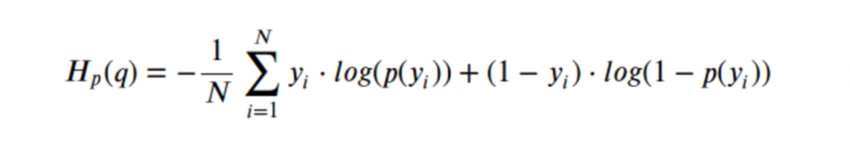

Image credit: https://www.researchgate.net/publication/374982515/figure/fig11/AS:11431281201335552@1698324423520/Binary-cross-entropy-loss-function-equation-Kum23.ppm

# Now we would start our training process and then compute the gradients

In [46]:
import jax
from jax import tree_map

def loss_fn(params, batch):
    x, y = batch
    preds = apply_fn(params, x)
    return binary_cross_entropy(preds, y)

def update(params, batch, lr=0.0003):
    grads = grad(loss_fn)(params, batch)
    return tree_map(lambda p, g: p - lr * g, params, grads)


i think this code is easy to comprehend now
we are just calculating the loss and then performing gradient descent

In [50]:
preds = apply_fn(params, X_test)
pred_labels = (preds > 0.5).astype(jnp.float32)
accuracy = jnp.mean(pred_labels == y_test)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.48


Well the accuracy is wayyy too low ..our model is performing worse than random guessing but probable reason for that was that we took a small subset of the entire dataset

However this was just a tutorial to give you the idea of how a neural network is built for a project in JAX and how we train it.
